# Pytorch Workflow

Let's explore example of an end-to-end pytorch workflow

In [1]:
topics_covered = {1: "data prepare and load",
                  2: "build model",
                  3: "fitting the model to data(training)",
                  4: "making predictions and evaluating a model(inference)",
                  5: "saving and loading a model",
                  6: "putting it all together"}

topics_covered

{1: 'data prepare and load',
 2: 'build model',
 3: 'fitting the model to data(training)',
 4: 'making predictions and evaluating a model(inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.12.1+cu113'

## 1. Data Preparing and Loading ##

Data can be anything

* Excel sheets
* Images
* VIdeos
* Audio
* DNA
* Text

Machine learning is a game of two parts:

1. Convert  data to numerical representation
2. Build a model to learn the patterns in numerical representation

To showcase this, let's create and prepare some data

We will use a linear regression formula to make a straight line with known parameter.

In [3]:
# create known parameter

weight = 0.9
bias = 0.3

# create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1) 

y = X * weight + bias

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3180],
         [0.3360],
         [0.3540],
         [0.3720],
         [0.3900],
         [0.4080],
         [0.4260],
         [0.4440],
         [0.4620]]))

### Splitting data into training and test sets

Let's create a training and testing set with our data.

In [4]:
train_split = int(0.8* len(X))
X_train,y_train,X_test,y_test = X[:train_split],y[:train_split],X[train_split:],y[train_split:]


len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

How might we better visualize our data

This is where data explorer's motto comes in

` Visualize Visualize Visualize `

In [13]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plot training data, test data and compares predictions.
  """

  plt.figure(figsize=(10,7))

  # plot training data

  plt.scatter(train_data,train_labels,c="b",s=4,label="Training data")

  # plot test data

  plt.scatter(test_data,test_labels,c="g",s=4,label="Test data")

  # Are there predictions?
  if predictions is not None:
    plt.scatter(test_data,predictions,c="r",s=4,label="predictions")
  
  # show the legend
  plt.legend(prop={"size" : 14})
  

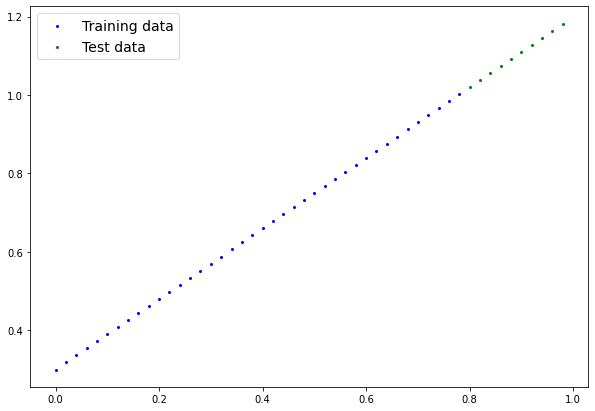

In [8]:
plot_predictions()

## 2. Building model ##

First Pytorch model

What our model does:

* Start with random values
* Look at training data and adjust the random values to better represent the ideal values.

How does it do so?

Through two main algorithms:

1. Gradient Descent
2. Backpropagation

In [68]:
# Create a linear regression Model
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super(LinearRegressionModel,self).__init__()
    self.weights = nn.Parameter(torch.rand(1,
                                           dtype=torch.float32))
    self.bias = nn.Parameter(torch.rand(1,dtype=torch.float32))


  def forward(self,x : torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

  

### Pytorch Model building essentials ###

* torch.nn -  contains all of the buildings for computational grapsh (another word of neural networks)
* torch.nn.Parameter - what parameters should a model try and learn
* torch.nn.Module -  The base class for all neural network modules, if you subclass it, you should override forward() method.
* torch.optim - this is where the optimizers live, they will help the gradient descent.
* def forward() - all nn.Module subclasses, require you to override forward(), this method defines what will happen in forward pass.

### Checking the contents of pytorch model

Now, we have created a model, lets see what we have inside the model.

So, we can check our model parameters using `.parameters()`

In [87]:
# create a random seed
#torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True), Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [70]:
# list named parameters
model_0.state_dict()


OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

### Make prediction using torch.inference_mode ###


In [71]:
with torch.inference_mode():
  y_pred = model_0(X_test)

y_pred

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

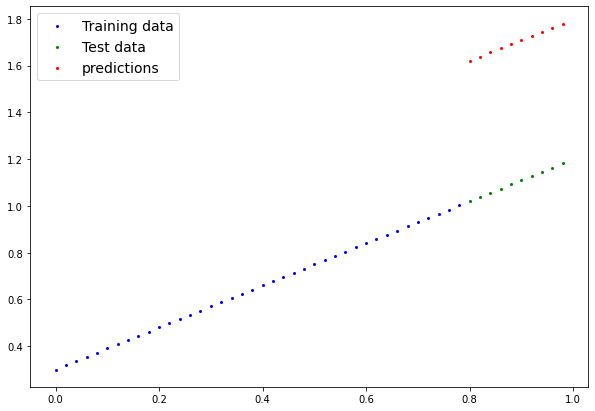

In [72]:
plot_predictions(predictions=y_pred)

## 3. Train Model ##

Things we need to train model:

1. **Loss Function** : A function to measure how wrong our model's prediction are compared to groundtruth.
2. **Optimizer** : Takes into account loss function and update the model's weights

And specifically for training in pytorch we need,
1. Training loop
2. Testing loop

In [59]:
# check out model's parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True), Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [88]:
loss_fn = torch.nn.L1Loss()

# setup an optimizer(Stochastic Gradient Descent)
optim = torch.optim.SGD(model_0.parameters(),lr=0.01) 


### Building a training loop (and a testing loop) in pytorch ###

A couple of things we need in a training loop

0. Loop through the data
1. Forward pass (this involve's data moving through our model's `forward()` functions) - also called forward propagations.
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with  respect to loss
5. Optimizer step - use optimizer to update the weights


In [74]:
with torch.inference_mode():
  print(list(model_0.parameters()))

[Parameter containing:
tensor([0.8823], requires_grad=True), Parameter containing:
tensor([0.9150], requires_grad=True)]


In [89]:
torch.manual_seed(42)

#  An epoch is one loop through data
epochs = 200

# Track different values
epoch_count = []
train_loss_values = []
test_loss_values = []

### Training
# 0. loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # train mode in pytorch set

  # 1. Forward pass
  preds = model_0(X_train)

  # 2. calculate loss
  loss = loss_fn(preds,y_train)

  #print(f"Loss : {loss:.3f}")

  # 3. optimizer zero grad

  optim.zero_grad()

  # 4 Perform back propagation
  loss.backward()

  # 5. update parameters of the model
  optim.step()


  # Testing
  model_0.eval() # turns off different settings which are not needed for model evaluation/testing(dropout,batchnorm)

  with torch.inference_mode(): # turns of gradient tracking & a couple of more things behind the scenes
    # 1. Do Forward pass
    test_pred = model_0(X_test)

    # 2. calculate the loss
    test_loss = loss_fn(test_pred,y_test)

  
  if epoch % 10 == 0:
    epoch_count.append(epoch) 
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch : {epoch} | Loss : {loss:.3f} | Test Loss : {test_loss:.3f}")
    print(model_0.state_dict())



Epoch : 0 | Loss : 0.608 | Test Loss : 0.586
OrderedDict([('weights', tensor([0.8784])), ('bias', tensor([0.9050]))])
Epoch : 10 | Loss : 0.493 | Test Loss : 0.451
OrderedDict([('weights', tensor([0.8394])), ('bias', tensor([0.8050]))])
Epoch : 20 | Loss : 0.378 | Test Loss : 0.316
OrderedDict([('weights', tensor([0.8004])), ('bias', tensor([0.7050]))])
Epoch : 30 | Loss : 0.262 | Test Loss : 0.182
OrderedDict([('weights', tensor([0.7614])), ('bias', tensor([0.6050]))])
Epoch : 40 | Loss : 0.147 | Test Loss : 0.047
OrderedDict([('weights', tensor([0.7224])), ('bias', tensor([0.5050]))])
Epoch : 50 | Loss : 0.052 | Test Loss : 0.066
OrderedDict([('weights', tensor([0.6930])), ('bias', tensor([0.4185]))])
Epoch : 60 | Loss : 0.041 | Test Loss : 0.087
OrderedDict([('weights', tensor([0.7003])), ('bias', tensor([0.3905]))])
Epoch : 70 | Loss : 0.038 | Test Loss : 0.085
OrderedDict([('weights', tensor([0.7156])), ('bias', tensor([0.3790]))])
Epoch : 80 | Loss : 0.034 | Test Loss : 0.079
Ord

In [93]:
import numpy as np

Text(0.5, 0, 'EPoch')

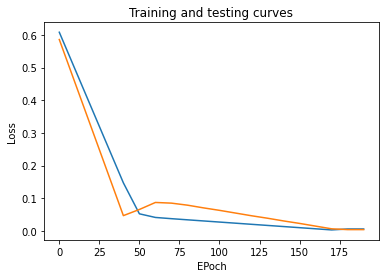

In [97]:
# plot loss curves
plt.plot(epoch_count,np.array(torch.tensor(train_loss_values).numpy()),label='train_loss')
plt.plot(epoch_count,np.array(torch.tensor(test_loss_values).numpy()),label='test_loss')
plt.title("Training and testing curves")
plt.ylabel("Loss")
plt.xlabel("EPoch")

In [83]:
weight,bias

(0.9, 0.3)

In [107]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

y_preds_new

tensor([[1.0112],
        [1.0291],
        [1.0470],
        [1.0649],
        [1.0827],
        [1.1006],
        [1.1185],
        [1.1363],
        [1.1542],
        [1.1721]])

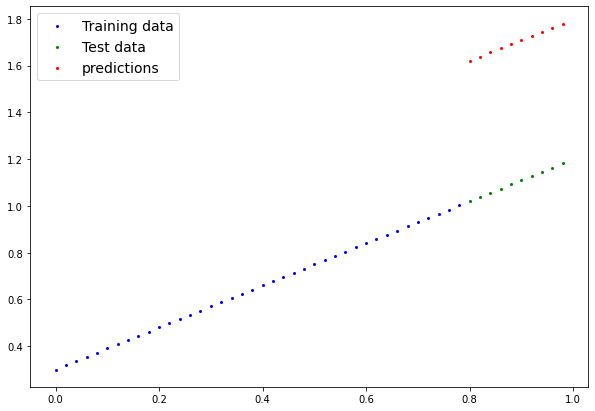

In [90]:
plot_predictions(predictions=y_pred)

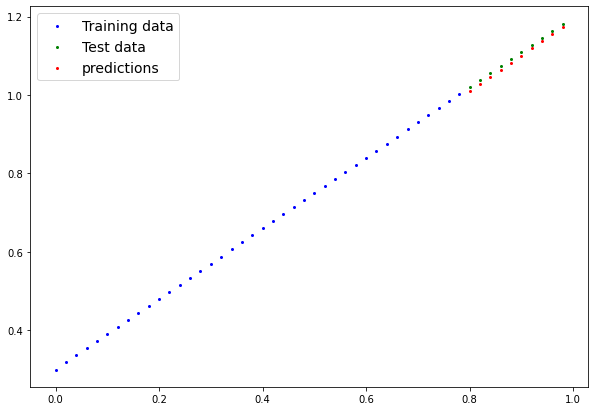

In [108]:
plot_predictions(predictions=y_preds_new)

## Saving a model in pytorch ##

There are three main methods you should know about for saving and loading models in pytorch

1. `torch.save()` - allows you to save pytorch model in python's pickle format
2. `torch.load()` - allows you to load pytorch model
3. `torch.nn.Module.load_state_dict()` - this allows a model's saved state dictionary to load

In [100]:
# saving our pytorch model
from pathlib import Path

#1. create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create model save path
MODEL_NAME ='01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(),MODEL_SAVE_PATH)

Saving model to : models/01_pytorch_workflow_model_0.pth


## Loading a pytorch model
Since we saved only state_dict() rather than entire model, we need to create instance of model and then load the state dictionary into that new instance's state dictionary.

In [105]:
# create new instance of the model
new_model = LinearRegressionModel()
new_model.state_dict()

# load the state dictionary in new instance
new_model.load_state_dict(torch.load(MODEL_SAVE_PATH,map_location='cpu'))

<All keys matched successfully>

In [109]:
#make some predictions with loaded model
new_model.eval()
with torch.inference_mode():
  loaded_model_preds = new_model(X_test)

y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together


In [43]:
# Import Pytorch and matplotlib
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pathlib
# Check pytorch version
torch.__version__

'1.12.1+cu113'

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it(for potentially faster computing).

If we dont have then code will use CPU.

In [14]:
# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 6.1 Data

In [3]:
# create some data using the linear regression formula y = weight * X + bias
weight = 0.7
bias = 0.3

# create range values
start = 0
end = 7
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)

y = weight * X + bias

X[:10],y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
# split data
train_split = int(0.8*len(X))
X_train,X_test,y_train,y_test = X[:train_split],X[train_split:],y[:train_split],y[train_split:]
len(X_train),len(X_test),len(y_train),len(y_test)

(280, 70, 280, 70)

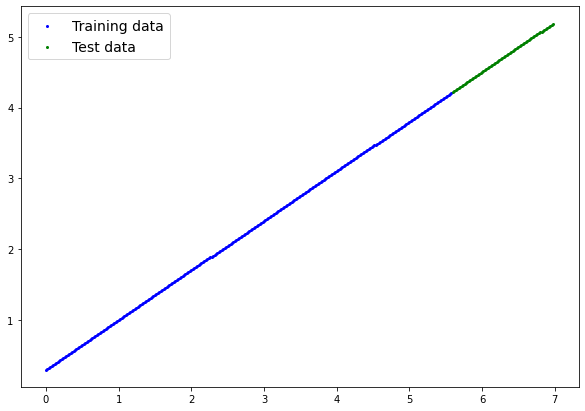

In [15]:
plot_predictions(train_data=X_train,train_labels=y_train,test_data=X_test,test_labels=y_test)

## 6.2 Build Pytorch Linear Model

In [48]:
# create a linear model by subclassing nn.Module class
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear for creating a model parameters / also called linear layer, probing layer, dense layer, fully connected layer
    self.linear = nn.Linear(1,1,bias=True)
  def forward(self,x):
    return self.linear(x)

In [33]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1.state_dict()

OrderedDict([('linear.weight', tensor([[0.7645]])),
             ('linear.bias', tensor([0.8300]))])

In [34]:
# check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [35]:
# bringing model on cuda
model_1.to(device)

LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [36]:
# check the model current device
next(model_1.parameters()).device

device(type='cuda', index=0)

## 6.3 Training ##

For training we need

. Loss Function
. Optimizer
. Training Loop
. Testing Loop

In [37]:
# setup loss function
l1_loss = nn.L1Loss()

# setup optimizer
optim = torch.optim.SGD(model_1.parameters(),lr=0.01)

In [20]:
# put data on target device
X_train,X_test,y_train,y_test = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)

In [38]:
# setup training loop
torch.manual_seed(42)

epochs = 200

for epoch in range(epochs):

  model_1.train()

  # 1. Forward pass

  y_preds = model_1(X_train)

  # 2. calculate loss
  loss = l1_loss(y_preds,y_train)

  #print(f"Loss : {loss}")

  # 3. Optimize zero grad
  optim.zero_grad()

  # 4. Backward propagate loss
  loss.backward()

  # 5.Update the model parameters
  optim.step()

  model_1.eval()

  with torch.inference_mode():

    test_pred = model_1(X_test)

    test_loss = l1_loss(test_pred,y_test) 

  
  if epoch % 10 == 0:
    print(f'Epoch : {epoch} | Loss : {loss} | Test_loss : {test_loss}')





Epoch : 0 | Loss : 0.7100704312324524 | Test_loss : 0.7504642605781555
Epoch : 10 | Loss : 0.1870928704738617 | Test_loss : 0.2750534117221832
Epoch : 20 | Loss : 0.17088958621025085 | Test_loss : 0.2536323666572571
Epoch : 30 | Loss : 0.15470224618911743 | Test_loss : 0.22858178615570068
Epoch : 40 | Loss : 0.13851198554039001 | Test_loss : 0.2053459733724594
Epoch : 50 | Loss : 0.12232505530118942 | Test_loss : 0.1802954226732254
Epoch : 60 | Loss : 0.10613441467285156 | Test_loss : 0.15705963969230652
Epoch : 70 | Loss : 0.08994747698307037 | Test_loss : 0.1320091038942337
Epoch : 80 | Loss : 0.07375729829072952 | Test_loss : 0.10695864260196686
Epoch : 90 | Loss : 0.05756980553269386 | Test_loss : 0.0837230235338211
Epoch : 100 | Loss : 0.04138011857867241 | Test_loss : 0.05867261812090874
Epoch : 110 | Loss : 0.06775056570768356 | Test_loss : 0.032976165413856506
Epoch : 120 | Loss : 0.06247802451252937 | Test_loss : 0.0036150729283690453
Epoch : 130 | Loss : 0.07011004537343979 |

In [40]:
model_1.state_dict()

OrderedDict([('linear.weight', tensor([[0.6718]], device='cuda:0')),
             ('linear.bias', tensor([0.2999], device='cuda:0'))])

## 6.4 Making and evaluating predictions ##

In [41]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on  test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[4.0623],
        [4.0757],
        [4.0892],
        [4.1026],
        [4.1160],
        [4.1295],
        [4.1429],
        [4.1564],
        [4.1698],
        [4.1832],
        [4.1967],
        [4.2101],
        [4.2235],
        [4.2370],
        [4.2504],
        [4.2639],
        [4.2773],
        [4.2907],
        [4.3042],
        [4.3176],
        [4.3310],
        [4.3445],
        [4.3579],
        [4.3713],
        [4.3848],
        [4.3982],
        [4.4117],
        [4.4251],
        [4.4385],
        [4.4520],
        [4.4654],
        [4.4788],
        [4.4923],
        [4.5057],
        [4.5192],
        [4.5326],
        [4.5460],
        [4.5595],
        [4.5729],
        [4.5863],
        [4.5998],
        [4.6132],
        [4.6267],
        [4.6401],
        [4.6535],
        [4.6670],
        [4.6804],
        [4.6938],
        [4.7073],
        [4.7207],
        [4.7341],
        [4.7476],
        [4.7610],
        [4.7745],
        [4.7879],
        [4

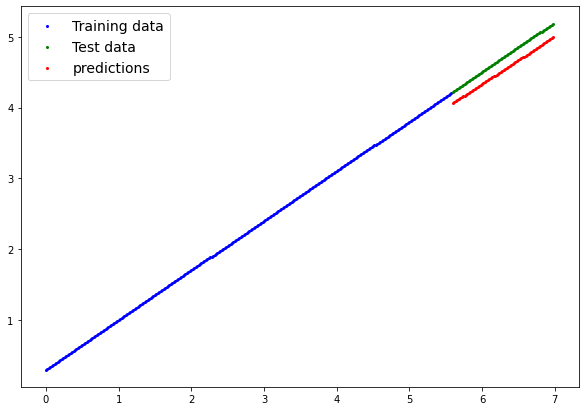

In [42]:
# check out our model predictions visually

plot_predictions(predictions=y_preds.detach().cpu().numpy())

## 6.5 Saving and loading models ##

In [46]:

# 1. Create Models dictionary
MODEL_PATH = pathlib.Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(model_1.state_dict(),MODEL_SAVE_PATH)


Saving model to models/01_pytorch_workflow_model_1.pth


In [47]:
# Load pytorch model
loaded_model_1 = torch.load(MODEL_SAVE_PATH,map_location=device)

# create new model
new_model_1 = LinearRegressionModelV2()

# load new model with saved parameters
new_model_1.load_state_dict(loaded_model_1)



<All keys matched successfully>

In [51]:
new_model_1.to(device) 


LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [52]:
# evaluate model
new_model_1.eval()
with torch.inference_mode():

  test_pred_new = new_model_1(X_test) 

test_pred_new == test_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        